In [61]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns


data_dir = "ex_out"

### Parsing the OHLCV Data:

A few notes here:
1. Be sure to select for the correct symbol you are desiring to pull statistics/visualizations for. Here the example shows how to select all columns corresponding to the symbol DOGE/USD.
2. **IMPORTANT**: Kraken Websockets ping with OHLCV data more frequently than the desired resolution. This means we need to do a `groupby()` on the time column, and then take the last entry in order to get one one typically thinks of as the "OHLCV" data.


In [110]:
ohlcdf = pd.read_csv(f"{data_dir}/OHLC.csv")

# Select only DOGE/USD
dogedf = ohlcdf[ohlcdf["symbol"] == "DOGE/USD"]

# Groupby 
dogedf = dogedf.groupby("timestamp").last().reset_index()


# Create figure with secondary y-axis
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.03, 
                    row_heights=[0.7, 0.3])

# Add candlestick chart
fig.add_trace(go.Candlestick(x=dogedf['timestamp'],
                            open=dogedf['open'],
                            high=dogedf['high'],
                            low=dogedf['low'],
                            close=dogedf['close'],
                            name='OHLC'),
                            row=1, col=1)

# Add volume bars
fig.add_trace(go.Bar(x=dogedf['timestamp'],
                     y=dogedf['volume'],
                     name='Volume',
                     marker_color='rgba(100,100,100,0.5)'),
                     row=2, col=1)

# Update layout
fig.update_layout(
    title='DOGE/USD Price and Volume',
    yaxis_title='Price',
    yaxis2_title='Volume',
    template='plotly_dark',
    xaxis_rangeslider_visible=False,  # Disable rangeslider
    height=800  # Increase overall height of the figure
)

# Update y-axes labels
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)

fig.show()
ohlcdf.head()

,timestamp,symbol,open,high,low,close,volume,vwap,trades,tstart,ttrue
0,2024-10-30T00:21:00.000000Z,BTC/USD,72375.0,72396.4,72368.0,72368.0,0.122587,72386.5,85,2024-10-30T00:20:00.000000000Z,2024-10-30T00:29:02.921971487Z
1,2024-10-30T00:22:00.000000Z,BTC/USD,72368.1,72400.0,72367.6,72384.5,0.274488,72379.2,39,2024-10-30T00:21:00.000000000Z,2024-10-30T00:29:02.921971487Z
2,2024-10-30T00:23:00.000000Z,BTC/USD,72384.6,72385.0,72369.8,72373.1,0.212518,72380.6,59,2024-10-30T00:22:00.000000000Z,2024-10-30T00:29:02.921971487Z
3,2024-10-30T00:24:00.000000Z,BTC/USD,72364.6,72364.6,72344.9,72352.4,2.175711,72346.7,37,2024-10-30T00:23:00.000000000Z,2024-10-30T00:29:02.921971487Z
4,2024-10-30T00:25:00.000000Z,BTC/USD,72347.6,72347.6,72337.7,72344.2,2.686447,72341.0,28,2024-10-30T00:24:00.000000000Z,2024-10-30T00:29:02.921971487Z


### Parsing the L1 Data:

In [11]:
l1df = pd.read_csv(f"{data_dir}/L1.csv")
l1df.head()

,timestamp,symbol,bid,bid_qty,ask,ask_qty,last,volume,vwap,low,high,change,change_pct
0,2024-10-29 18:08:10.456478,BTC/USD,72494.500000,0.048965,72494.600000,7.389896,72494.500000,3.120228e+03,71936.80000,69720.100000,73574.900000,2694.500000,3.86
1,2024-10-29 18:08:10.456717,DOGE/USD,0.175859,6075.000000,0.175923,4689.239751,0.175861,2.470833e+08,0.16981,0.160497,0.179604,0.015326,9.55
2,2024-10-29 18:08:11.705749,BTC/USD,72494.500000,0.069556,72494.600000,7.074932,72494.500000,3.120228e+03,71936.80000,69720.100000,73574.900000,2694.500000,3.86
3,2024-10-29 18:08:15.336034,BTC/USD,72494.500000,0.048865,72494.600000,4.669289,72494.600000,3.120228e+03,71936.80000,69720.100000,73574.900000,2696.300000,3.86
4,2024-10-29 18:08:26.074338,DOGE/USD,0.175923,182187.742448,0.176132,62.439185,0.175924,2.470831e+08,0.16981,0.160500,0.179604,0.015423,9.61


### Parsing the L2 Data:

1. If in `append_mode` the book is stored over time at the desire depth. There will be one file per symbol. Here we look at loading in the single symbol DOGE/USD. Note that the file name will be converted from QUOTE/BASE to QUOTE_BASE to avoid filesystem issues.

These dataframes have columns ordered as follows, with `D` being the depth:

`timestamp`, `ap0`, ...`apD`, `av0`, ...`avD`, `bp0`, ...`bpD`, `bv0`, ...`bvD`

Where the notation is consistent with the following:

`ap->ask_price`

 `av->ask_volume`
 
  `bp->bid_price`
  
   `bv->bid_volume`


In [12]:
l2df = pd.read_csv(f"{data_dir}/L2_DOGE_USD_orderbook.csv") 
l2df.head()

,timestamp,ap0,ap1,ap2,ap3,ap4,ap5,ap6,ap7,ap8,...,bv0,bv1,bv2,bv3,bv4,bv5,bv6,bv7,bv8,bv9
0,2024-10-29T23:41:35.868941Z,0.175822,0.175822,0.175832,0.175844,0.175869,0.17587,0.175877,0.175878,0.175884,...,38.475545,3037.500000,9595.394211,4302.2,3037.5,4290.0,3037.500000,4802.233947,4302.2,3037.500000
1,2024-10-29T23:41:35.872777Z,0.175822,0.175822,0.175832,0.175844,0.175869,0.17587,0.175877,0.175878,0.175884,...,9633.869756,3037.500000,9595.394211,4302.2,3037.5,4290.0,3037.500000,4802.233947,4302.2,3037.500000
2,2024-10-29T23:41:35.874902Z,0.175822,0.175822,0.175832,0.175844,0.175869,0.17587,0.175877,0.175878,0.175884,...,9633.869756,3037.500000,9595.394211,4302.2,3037.5,4290.0,3037.500000,4802.233947,4302.2,3037.500000
3,2024-10-29T23:41:36.056382Z,0.175822,0.175822,0.175832,0.175844,0.175869,0.17587,0.175877,0.175878,0.175884,...,9633.869756,9595.394211,4302.200000,3037.5,4290.0,3037.5,4802.233947,4302.200000,3037.5,17397.527875
4,2024-10-29T23:41:36.059977Z,0.175822,0.175822,0.175832,0.175844,0.175869,0.17587,0.175877,0.175878,0.175884,...,38.475545,9595.394211,4302.200000,3037.5,4290.0,3037.5,4802.233947,4302.200000,3037.5,17397.527875


2. Regardless of whether or not in `append_mode`, the book at a given point will be stored in the `L2_live_orderbooks.json` file.

These dictionaries have the following structure:

```python
data = {
    symbol: {
        b:{
            price_level_0:volume_0,
            ...
            price_level_D:volume_D
        },
        a:{
            ... 
        }
    }
}
```

In [13]:
with open(f"{data_dir}/L2_live_orderbooks.json", "r") as fil:
    data = json.load(fil)

print(data)

{'BTC/USD': {'bids': {'72693.7': 1.14088643, '72690.7': 0.4123544, '72686.6': 0.01588097, '72686.4': 0.39561, '72683.0': 0.0001, '72682.3': 0.25, '72679.4': 0.0001, '72679.3': 0.0032, '72679.2': 0.03005553, '72675.9': 0.00079973}, 'asks': {'72693.8': 0.0021, '72705.5': 0.0014778, '72709.0': 0.0408, '72709.7': 0.00138136, '72715.2': 0.00113373, '72716.2': 0.0063321, '72716.6': 0.212457, '72718.2': 0.03947498, '72719.3': 0.00028132, '72722.7': 0.00154524}}, 'DOGE/USD': {'bids': {'0.1758697': 2843.01389039, '0.1758403': 1933.24, '0.1758172': 47.89145721, '0.1758169': 3037.5, '0.1757959': 2247.72218181, '0.1757958': 6510.41045452, '0.1757957': 3037.5, '0.1757927': 3110.0, '0.1757851': 4172.9, '0.1757699': 3037.5}, 'asks': {'0.1758698': 12632.89421078, '0.1758817': 3037.5, '0.1758871': 4172.9, '0.1759002': 3037.5, '0.1759141': 3130.0, '0.1759177': 17807.85647346, '0.1759178': 3037.5, '0.175922': 4000.0, '0.1759244': 1057.10552419, '0.1759301': 2290.26024424}}}


### Parsing the Trades Data:

Beware these also write to only one file even if multiple symbols are being traded. Be sure to select the relevant data from your DataFrame accordingly.

In [113]:
tdf = pd.read_csv(f"{data_dir}/trades.csv")
tdf.head()

,ts_event,symbol,price,qty,side,ord_type,trade_id
0,2024-10-30T00:43:22.778845Z,BTC/USD,72178.2,0.000155,buy,limit,75084477
1,2024-10-30T00:43:22.780390Z,BTC/USD,72178.2,0.000155,buy,limit,75084478
2,2024-10-30T00:43:22.781595Z,BTC/USD,72178.2,0.000155,buy,limit,75084479
3,2024-10-30T00:43:22.783631Z,BTC/USD,72178.2,0.000155,buy,limit,75084480
4,2024-10-30T00:43:22.786578Z,BTC/USD,72178.2,0.000155,buy,limit,75084481


### Parsing the L3 data 

The columns here are self-explanatory, but below I give some basic examples of analyzing the basic properties of the stored data.

In [132]:
l3df = pd.read_csv(f"{data_dir}/L3_ticks.csv")

l3_doge = l3df[l3df["symbol"] == "DOGE/USD"]

l3_doge.head()

,side,timestamp,price,size,event,order_id,symbol
6,b,2024-10-29T23:53:46.305294966Z,0.175717,3037.500000,add,OVAJOQ-JTBU4-AVBYA7,DOGE/USD
37,b,2024-10-29T23:53:46.142479615Z,0.175707,41.438310,delete,OW42SE-MFP6Y-7B5U67,DOGE/USD
38,b,2024-10-29T23:53:45.968421413Z,0.175640,253.826405,add,OAXO4X-IM7HH-GUE6NP,DOGE/USD
39,b,2024-10-29T23:53:46.339076109Z,0.175640,41.800035,add,OW42SE-MFP6Y-7B5U67,DOGE/USD
40,b,2024-10-29T23:53:46.354018700Z,0.175717,3037.500000,delete,OVAJOQ-JTBU4-AVBYA7,DOGE/USD


[]

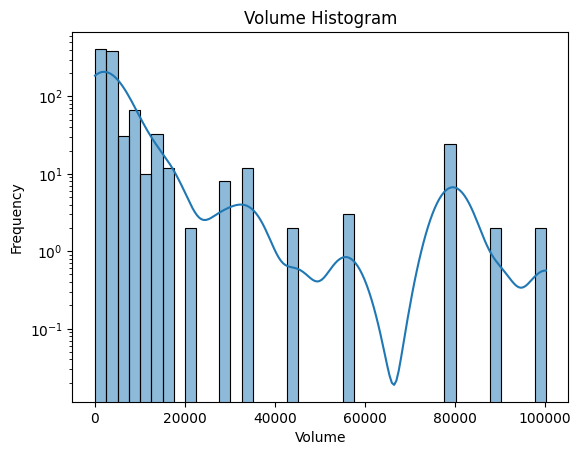

In [133]:
sns.histplot(l3_doge["size"], bins=40, kde=True)
plt.title("Volume Histogram")
plt.xlabel("Volume")
plt.ylabel("Frequency")
plt.semilogy()

<Axes: xlabel='event'>

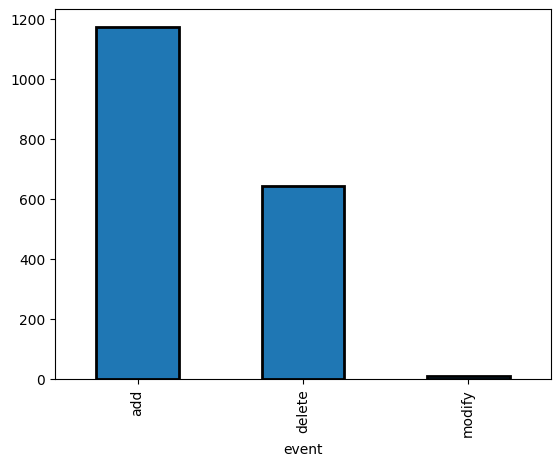

In [139]:
l3df["event"].value_counts().plot(kind="bar", edgecolor='k', linewidth=2)

### End